In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import math

In [2]:
file_name = "Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
# this file can be got from here; https://blog.minethatdata.com/2008/03/minethatdata-e-mail-analytics-and-data.html

# load dataset file as pandas.DataFrame

In [3]:
df = pd.read_csv(file_name)

# EDA

In [4]:
df.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 12 columns):
recency            64000 non-null int64
history_segment    64000 non-null object
history            64000 non-null float64
mens               64000 non-null int64
womens             64000 non-null int64
zip_code           64000 non-null object
newbie             64000 non-null int64
channel            64000 non-null object
segment            64000 non-null object
visit              64000 non-null int64
conversion         64000 non-null int64
spend              64000 non-null float64
dtypes: float64(2), int64(6), object(4)
memory usage: 5.9+ MB


In [6]:
cat_cols   = [col for col in df.columns if df[col].dtype=="object" ]
dense_cols = [col for col in df.columns if df[col].dtype in ["int64", "float64"]]
print(f"categorical columns are: {cat_cols}.")
print(f"numerical columns are: {dense_cols}.")

categorical columns are: ['history_segment', 'zip_code', 'channel', 'segment'].
numerical columns are: ['recency', 'history', 'mens', 'womens', 'newbie', 'visit', 'conversion', 'spend'].


In [7]:
df.channel.value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

## create numerical features from categorical ones

In [8]:
# segment
df["dense_MensEmail"] = df.segment.apply(lambda x: x=="Mens E-Mail").astype(int)
df["dense_WomensEmail"] = df.segment.apply(lambda x: x=="Womens E-Mail").astype(int)
df["dense_NoEmail"] = df.segment.apply(lambda x: x=="No E-Mail").astype(int)
# history_segment
df["dense_hist_seg"] = df.history_segment.apply(lambda x: x[0]).astype(int)
# zip-code
conv_zipcode = {"Rural": 0, "Urban": 1, "Surburban": 2} 
# "Rural", "Urban", and "Surburban" has 9563, 25661, and 28776 records, respectively.
df["dense_zip"] = df.zip_code.apply(lambda x: conv_zipcode[x])
# channel
df["dense_isWeb"] = df.channel.apply(lambda x: x=="Web").astype(int)
df["dense_isPhone"] = df.channel.apply(lambda x: x=="Phone").astype(int)
df["dense_isMulti"] = df.channel.apply(lambda x: x=="Multichannel").astype(int)

## visualize histograms

[]

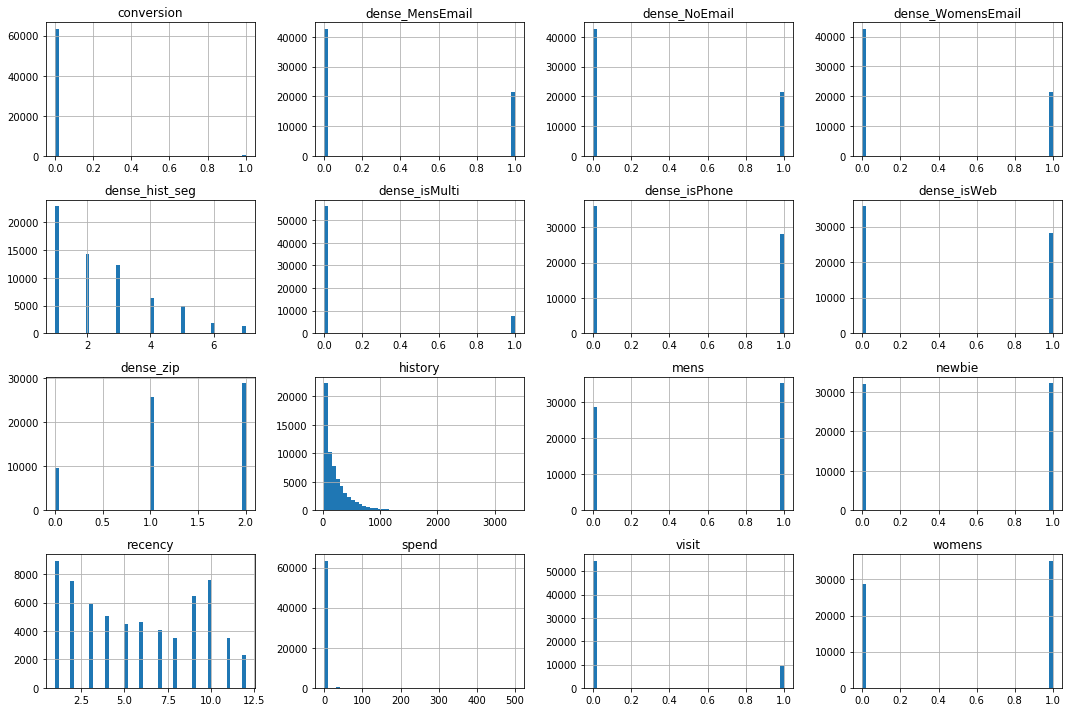

In [9]:
df.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.plot()

OGM most guys didn't make any conversion!! What's up guys!! Hey!!!!

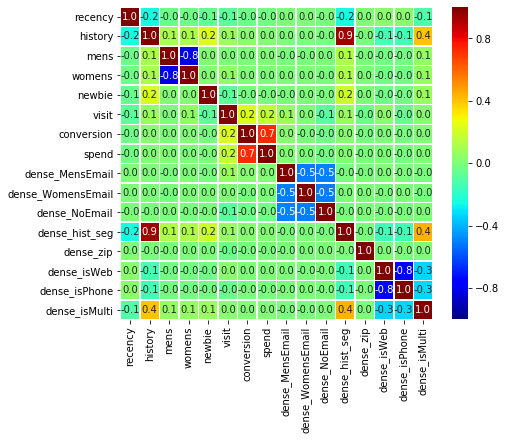

In [10]:
fig, ax = plt.subplots(1,1,figsize=(7, 7))
sns.heatmap(df.corr(), vmin=-1, center=0, vmax=1, square=True, annot=True, 
            fmt="1.1f", linewidths=.5, cmap="jet", ax=ax, cbar=True,cbar_kws={"shrink": .82})

Hmm, we can make sure the target of treatment of E-mail has no relations with user's condition/property.  
This dataset will be surely a randomly selected.

# progress analysis following text

## create "segment"

In [11]:
segs = list(df.segment.unique())
print(segs)

['Womens E-Mail', 'No E-Mail', 'Mens E-Mail']


In [12]:
df.segment.value_counts()

Womens E-Mail    21387
Mens E-Mail      21307
No E-Mail        21306
Name: segment, dtype: int64

# make new dataset; without users who recieved E-mail for women

[]

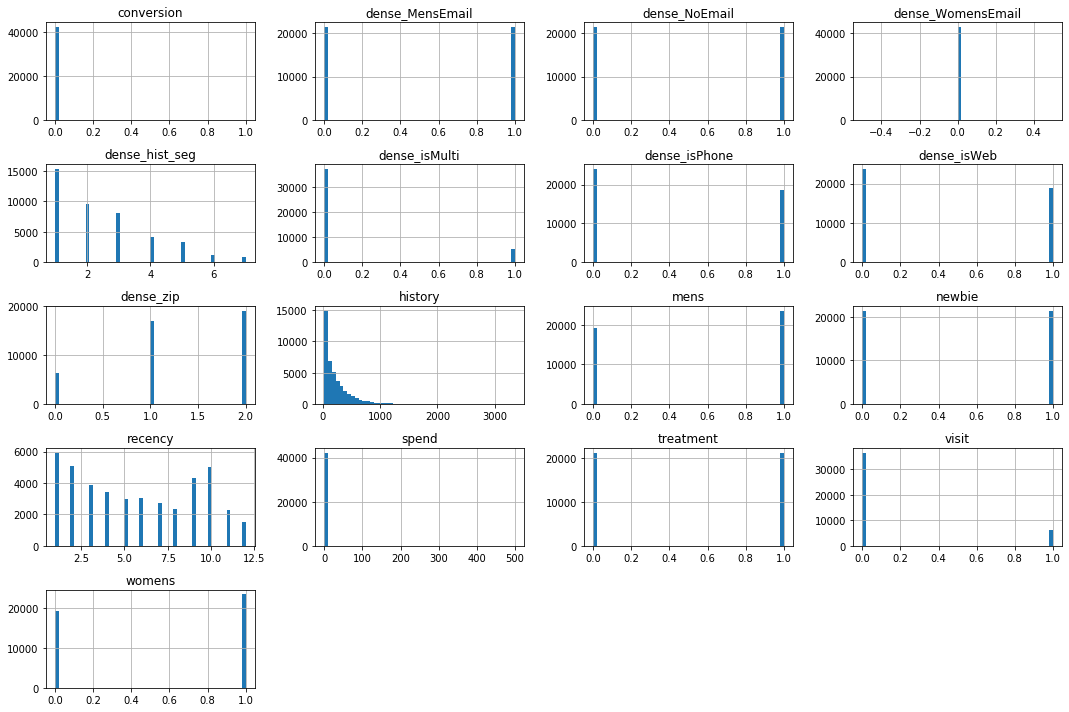

In [13]:
df_withoutWomen = df[df.segment!="Womens E-Mail"].copy()
# if user recieved E-mail for Men, then treatment=1
df_withoutWomen["treatment"] = df_withoutWomen.segment.apply(lambda x: 1 if x == "Mens E-Mail" else 0)

df_withoutWomen.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.plot()

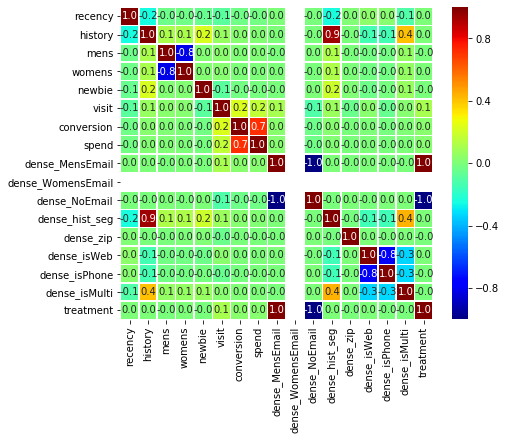

In [14]:
fig, ax = plt.subplots(1,1,figsize=(7, 7))
sns.heatmap(df_withoutWomen.corr(), vmin=-1, center=0, vmax=1, square=True, annot=True, 
            fmt="1.1f", linewidths=.5, cmap="jet", ax=ax, cbar=True,cbar_kws={"shrink": .82})

In [15]:
df_withoutWomen.groupby("treatment").agg(
    conversion_rate=("conversion", "mean"),
    spend_mean=("spend", "mean"),
    count=("treatment", "count")
)

,conversion_rate,spend_mean,count
treatment,,,
0,0.005726,0.652789,21306
1,0.012531,1.422617,21307


# t-test for df_withoutWomen

In [16]:
mens_mail = df_withoutWomen[df_withoutWomen.treatment==1].spend.values
no_mail = df_withoutWomen[df_withoutWomen.treatment==0].spend.values

t_test_res1 = stats.ttest_ind(mens_mail, no_mail)
print(t_test_res1)

Ttest_indResult(statistic=5.300090294465472, pvalue=1.163200872605869e-07)


# processing to let dataset bias

[]

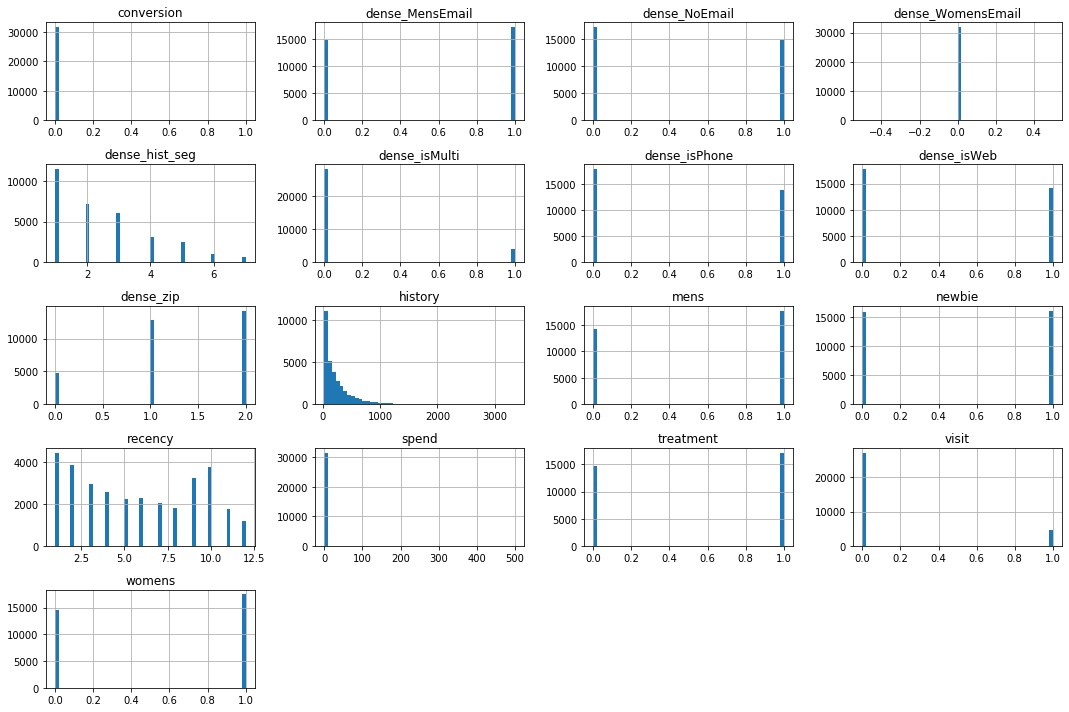

In [17]:
sampling_rules = (df_withoutWomen.history > 300) | (df_withoutWomen.recency < 6) | (df_withoutWomen.channel=="Multichannel")
df_withBias = pd.concat([
    df_withoutWomen[( sampling_rules) & (df_withoutWomen.treatment == 0)].sample(frac=0.5, random_state=1),
    df_withoutWomen[(~sampling_rules) & (df_withoutWomen.treatment == 0)],
    df_withoutWomen[( sampling_rules) & (df_withoutWomen.treatment == 1)],
    df_withoutWomen[(~sampling_rules) & (df_withoutWomen.treatment == 1)].sample(frac=0.5, random_state=1)
], axis=0, ignore_index=True)

df_withBias.hist(bins=50, figsize=(15,10))
plt.tight_layout()
plt.plot()

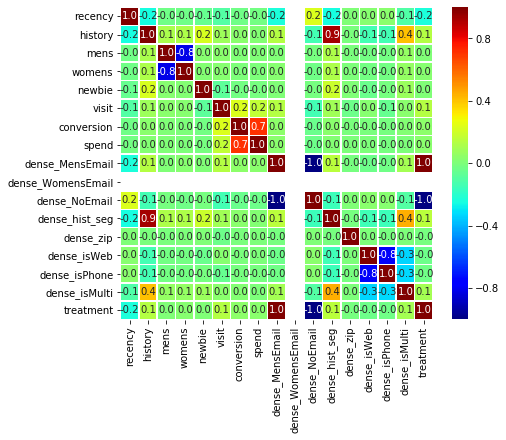

In [18]:
fig, ax = plt.subplots(1,1,figsize=(7, 7))
sns.heatmap(df_withBias.corr(), vmin=-1, center=0, vmax=1, square=True, annot=True, 
            fmt="1.1f", linewidths=.5, cmap="jet", ax=ax, cbar=True,cbar_kws={"shrink": .82})

In [19]:
df_withBias.groupby("treatment").agg(
    conversion_rate=("conversion", "mean"),
    spend_mean=("spend", "mean"),
    count=("treatment", "count")
)

,conversion_rate,spend_mean,count
treatment,,,
0,0.004540,0.557954,14757
1,0.013572,1.541704,17168


compared with above one, we can see the bias

# t-test for biased dataset (df_withBias)

In [20]:
bias_mens_mail = df_withBias[df_withBias.treatment==1].spend.values
bias_no_mail = df_withBias[df_withBias.treatment==0].spend.values

t_test_res2 = stats.ttest_ind(bias_mens_mail, bias_no_mail)
print(t_test_res2)

Ttest_indResult(statistic=5.595867225527975, pvalue=2.21319841336543e-08)


# Appendix

## t-distribution  
$$ \begin{align}
X_{0}, X_{1}, X_{2}, ... , X_{n} \stackrel{i.i.d.}{\sim} \mathcal N(\mu, \sigma^{2})
\end{align} $$
then,
$$ \begin{align}
s^{2} = \frac{ \sum_{i=1}^{n} X_{i} - \bar{X} }{ n-1 }
\end{align} $$

t-statistics  
$$ \begin{align}
t &= \frac{\bar{X} - \mu}{ \sqrt{ {s^{2} / n } } } \times \frac{1}{ \sqrt{\frac{ \sigma^{2} }{ \sigma^{2}} }} \\
&= \frac{ \frac{\bar{X} - \mu}{ \sqrt{ \sigma^{2} / n } } }{ \sqrt{s^{2} / \sigma^{2}} } \\
&= \frac{ \frac{\bar{X} - \mu}{ \sqrt{ \sigma^{2} / n } } }{ \sqrt{ \frac{   \frac{ (n-1) s^{2} }{ \sigma^{2} } }{ n-1 } } } 
\sim \frac{ \mathcal N(0, 1) }{ \chi^{2}(n-1) }
\end{align} $$
t-distribution (k degree of freedom)  
$$ \begin{align}
t = \frac{Z}{ \sqrt{Y / k} } \sim t(k) = \frac{ \Gamma{ ({\frac{k+1}{2}}) }} { \sqrt{ k\pi } \Gamma{ (\frac{k}{2}) } } {(1 + \frac{{t^2}}{k})}^{ -\frac{k+1}{2} }
\end{align} $$

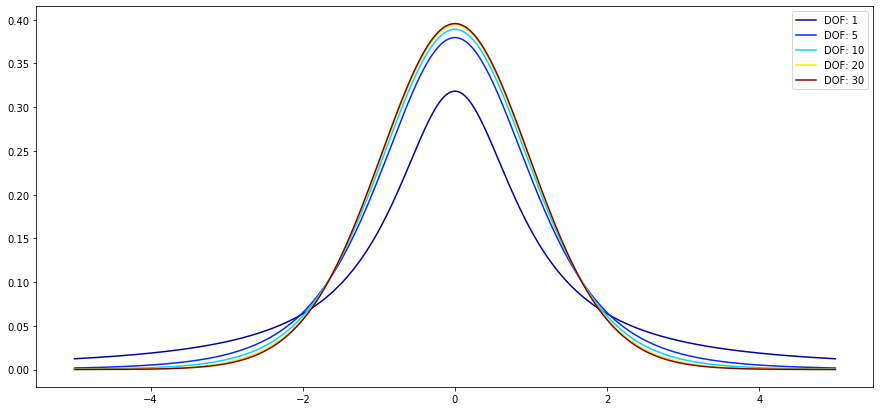

In [21]:
def t_pdf(x, mu, sigma2, k): # t-distribution probability density function
    """
    Args:
        x  :: x values for plot and create t-distribution
        mu :: mean value of x
        sigma2 :: unbiased variance of x
        k  :: degree of freedom (k = 1, 2, ...)
        t  :: t-statistics
    Retuen:
        np.array of t-distribution
    """
    t = (x - mu)/np.sqrt(sigma2/k+1)
    return math.gamma((k+1)/2)/( np.sqrt(k*np.pi) * math.gamma(k/2) ) * pow(1 + (t**2)/k, -(k+1)/2)

n = 5000
x = np.linspace(-5,5,n)
mu = np.mean(x)
sigma2 = (x - mu)**2/(n-1)

fig, ax = plt.subplots(1,1, figsize=(15,7))
ks = [1,5,10,20,30]
# if use only numpy and math module
[ax.plot(x, t_pdf(x, mu, sigma2, k), label=f"DOF: {k}", color=cm.jet(k/max(ks))) for k in ks]
# if use stat.t module; if you wanna use large k, then you should use this one
#[ax.plot(x, stats.t.pdf(x, k), label=f"DOF: {k}", color=cm.jet(k/max(ks))) for k in ks]

ax.legend()
plt.show()

## t-distribution for population of df_withoutWomen

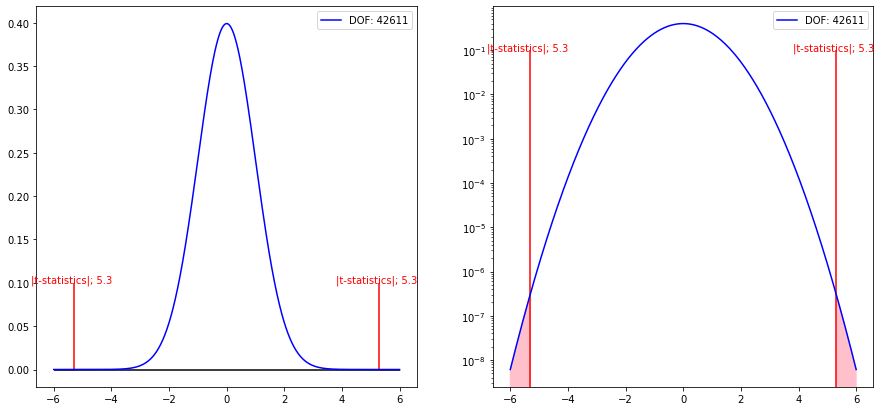

In [22]:
n = 1000
x = np.linspace(-6,6,n)
mu = np.mean(x)
sigma2 = (x - mu)**2/(n-1)

fig, axes = plt.subplots(1,2, figsize=(15,7))
k = len(mens_mail)+len(no_mail)-2
axes[0].plot(x, stats.t.pdf(x, k), label=f"DOF: {k}", color="b")
axes[1].plot(x, stats.t.pdf(x, k), label=f"DOF: {k}", color="b")
axes[1].set_yscale("log")
for ax in axes:
    ax.hlines(0, -6, 6)
    ax.vlines(   t_test_res1[0], 0, 0.1, color="r")
    ax.vlines(-1*t_test_res1[0], 0, 0.1, color="r")
    ax.text(   t_test_res1[0]-1.5, 0.1, f"|t-statistics|; {abs(t_test_res1[0]).round(2)}", c="r")
    ax.text(-1*t_test_res1[0]-1.5, 0.1, f"|t-statistics|; {abs(t_test_res1[0]).round(2)}", c="r")
    x_idxs_positive = [i for i, _ in enumerate(x) if _>t_test_res1[0]]
    x_idxs_negative = [i for i, _ in enumerate(x) if _<-1*t_test_res1[0]]
    ax.fill_between(x[x_idxs_positive], 0, stats.t.pdf(x, k)[x_idxs_positive], color="pink")
    ax.fill_between(x[x_idxs_negative], 0, stats.t.pdf(x, k)[x_idxs_negative], color="pink")
    ax.legend()
plt.show()

## t-distribution for population of df_withBias

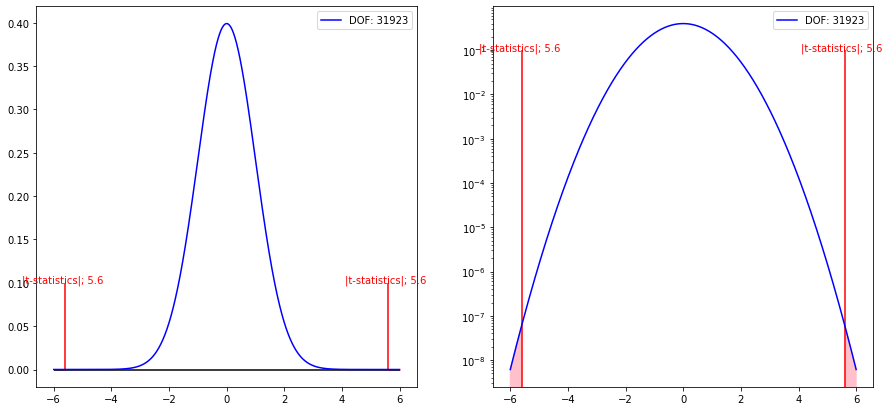

In [23]:
n = 1000
x = np.linspace(-6,6,n)
mu = np.mean(x)
sigma2 = (x - mu)**2/(n-1)

fig, axes = plt.subplots(1,2, figsize=(15,7))
k = len(bias_mens_mail)+len(bias_no_mail)-2
axes[0].plot(x, stats.t.pdf(x, k), label=f"DOF: {k}", color="b")
axes[1].plot(x, stats.t.pdf(x, k), label=f"DOF: {k}", color="b")
axes[1].set_yscale("log")
for ax in axes:
    ax.hlines(0, -6, 6)
    ax.vlines(   t_test_res2[0], 0, 0.1, color="r")
    ax.vlines(-1*t_test_res2[0], 0, 0.1, color="r")
    ax.text(   t_test_res2[0]-1.5, 0.1, f"|t-statistics|; {abs(t_test_res2[0]).round(2)}", c="r")
    ax.text(-1*t_test_res2[0]-1.5, 0.1, f"|t-statistics|; {abs(t_test_res2[0]).round(2)}", c="r")
    x_idxs_positive = [i for i, _ in enumerate(x) if _>t_test_res2[0]]
    x_idxs_negative = [i for i, _ in enumerate(x) if _<-1*t_test_res2[0]]
    ax.fill_between(x[x_idxs_positive], 0, stats.t.pdf(x, k)[x_idxs_positive], color="pink")
    ax.fill_between(x[x_idxs_negative], 0, stats.t.pdf(x, k)[x_idxs_negative], color="pink")
    ax.legend()
plt.show()

## chi-square distribution    
$$ \begin{align}
X_{0}, X_{1}, X_{2}, ... , X_{n} \stackrel{i.i.d.}{\sim} \mathcal N(\mu, \sigma^{2})
\end{align} $$
then,
$$ \begin{align}
s^{2} = \frac{ \sum_{i=1}^{n} X_{i} - \bar{X} }{ n-1 }
\end{align} $$


chi-square statistics and distribution (k degree of freedom)  
$$ \begin{align}
\chi^{2} = \frac{ (n-1)s^{2} }{ \sigma^{2} } \sim \chi^{2}(k)|_{k=n-1} = \frac{1}{ 2^{ \frac{k}{2} } \Gamma{ (\frac{k}{2}) } } x^{ \frac{k}{2}-1 } e^{ -\frac{x}{2} }
\end{align} $$

/Users/KazumasaSasahara/opt/anaconda3/envs/py4kaggle/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in power


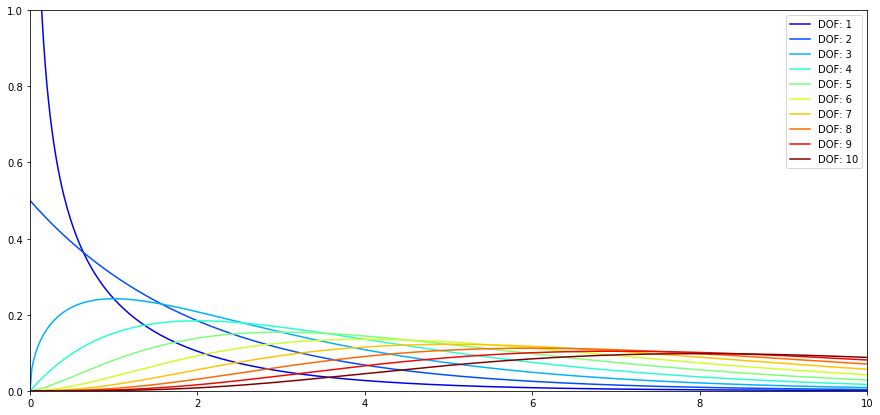

In [24]:
def chi_pdf(x, k): # t-distribution probability density function
    """
    Args:
        x  :: x values for plot and create t-distribution
        k  :: degree of freedom (k = 1, 2, ...)
    Retuen:
        np.array of chi-distribution
    """
    return 1/( pow(2, k/2) * math.gamma(k/2) ) * pow(x, k/2-1) * pow(math.e, -x/2)

n = 500
x = np.linspace(0,10,n)

fig, ax = plt.subplots(1,1, figsize=(15,7))
ks = [1,2,3,4,5,6,7,8,9,10]
# if use only numpy and math module
[ax.plot(x, chi_pdf(x, k), label=f"DOF: {k}", color=cm.jet(k/max(ks))) for k in ks]
# if use stat.t module; if you wanna use large k, then you should use this one
#[ax.plot(x, stats.chi2.pdf(x, k), label=f"DOF: {k}", color=cm.jet(k/max(ks))) for k in ks]

ax.legend()
ax.set_xlim(0,max(x))
ax.set_ylim(0,1)
plt.show()